# Lake model continued - sensitivity analysis

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

In assignment 6, we applied linear regression, Sobol, and extra-trees feature scoring to a simple predator-prey model. In this assignment, we take the best-performing methods (i.e. Sobol and extra-trees) and apply them to the lake problem.

*It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the separate anthropogenic release decision*

There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis.



## 1. SOBOL
1. Apply Sobol with 3 separate release policies (0, 0.05, and 0.1) and analyse the results for each release policy separately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each separate release policy and apply sobol to each of the three separate release policies. If this sounds too complicated, just do it on each release policy separately.*

In [1]:
from lakemodel_function import lake_problem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

First, we define the model, uncertainties, levers and outcomes. We also define the policies we want to use and run the experiments.

In [2]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [3]:
from ema_workbench import Policy

policies = [Policy('0', **{l.name:0 for l in lake_model.levers}),
            Policy('0.05', **{l.name:0.05 for l in lake_model.levers}),
            Policy('0.1', **{l.name:0.1 for l in lake_model.levers})]

In [4]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import Samplers
from ema_workbench.em_framework import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model, n_processes=-2) as evaluator:
    experiments, results = evaluator.perform_experiments(128, policies,
                                                         uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 1536 scenarios * 3 policies * 1 model(s) = 4608 experiments
100%|█████████████████████████████████████| 4608/4608 [00:09<00:00, 481.81it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
problem = get_SALib_problem(lake_model.uncertainties)
problem

{'num_vars': 5,
 'names': ['b', 'delta', 'mean', 'q', 'stdev'],
 'bounds': [(0.1, 0.45),
  (0.93, 0.99),
  (0.01, 0.05),
  (2.0, 4.5),
  (0.001, 0.005)]}

#### Sensitivity indexes

We will create a sensitivity index plot, displaying the S1 (First-order), S2 (Second-order), and ST (Total-order) sensitivity indexes, to compare the influence of input parameters on the reliability objective across three release policies. This will provide insights into the importance of different uncertainties under each policy.

In [6]:
from SALib.analyze.sobol import analyze

In [7]:
sobol_results = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = results['reliability'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

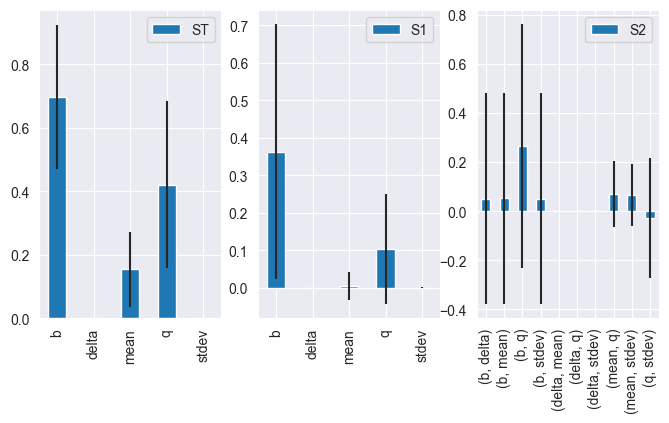

In [8]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(8, 4)
indices.plot(ax=axes)

The above figure shows side by side the total order (ST), first order (S1), and second order (S2) effects as estimated by Sobol. The black bars indicate the error bars for each estimated effect. We can see that sensitivity is driven by B and Q with a small role also for the mean. Most of the effect is due to S1 with only a small role for some interaction effect (i.e., S2) between b and q.

## 2. Feature scoring
Repeat the above analysis for the 3 release policies but now with extra trees [feature scoring](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results. See also the [features scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) section of the tutorial.*

In [10]:
from ema_workbench.analysis import feature_scoring

Feature scoring is a machine learning-based technique for global sensitivity analysis that ranks input parameters (uncertainties) based on their importance in determining the model's outputs. It is useful because it provides an alternative approach to understanding the influence of different parameters on the model outcomes, often with less computational cost.

In this section, we will apply extra trees feature scoring to the lake problem for all outcomes of interest and analyze the results under the three release policies. We will use the Sobol experiment results as input for extra trees and compare the outcomes with those obtained from Latin Hypercube Sampling. To visualize the results, we will create a series of heatmaps using seaborn, displaying the feature importances for each policy.

In [11]:
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

scores = feature_scoring.get_feature_scores_all(cleaned_experiments,results)

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


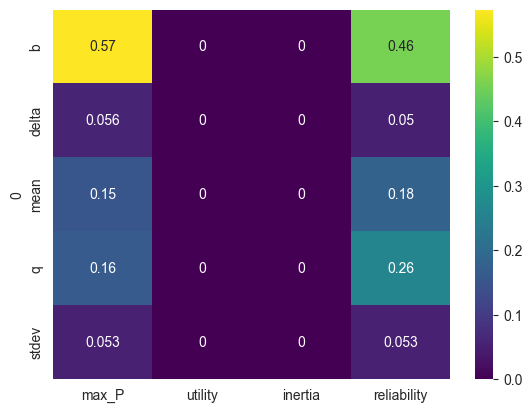

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


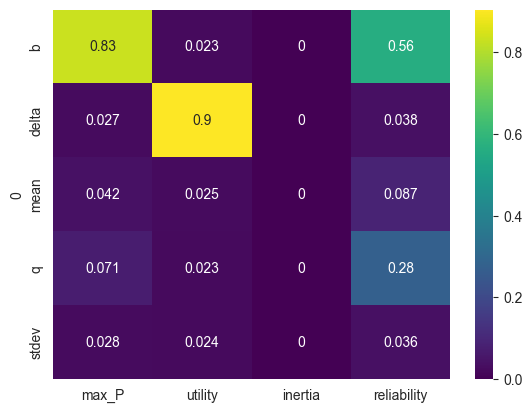

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


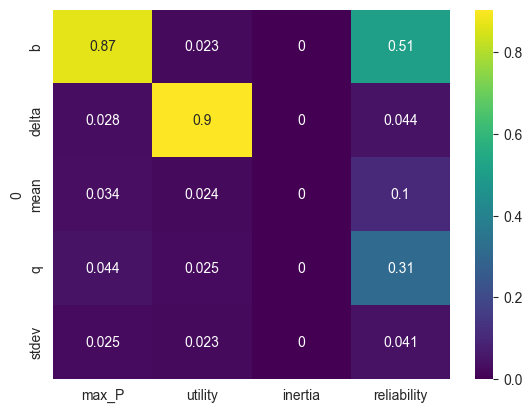

In [12]:
import seaborn as sns
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    subset_results = {k:v[logical] for k,v in results.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

This figure summarizes the feature scores as estimated by extra-trees feature scoring for each outcome of interest. So, max_P is primarily driven by B; utility is almost exclusively driven by delta; inertia is not sensitive to any uncertainty; a combination of B, Q, and a minor role for the mean drives reliability. If you want to understand why, like scenario discovery, you must go back to the model. For example, inertia measures changes in the anthropogenic release from one timestep to the next. This is entirely specified by the policy, and hence it makes sense that none of the uncertainties of the model affects this outcome of interest.

#### Concluding remarks
We performed sensitivity analysis on the lake problem, focusing on the reliability objective and considering three release policies (0, 0.05, and 0.1). We used two global sensitivity analysis methods: Sobol and extra trees feature scoring.

By creating a sensitivity index plot, we were able to compare the influence of input parameters on the reliability objective across the release policies, revealing insights into the importance of different uncertainties under each policy.

Next, we applied extra trees feature scoring for all outcomes of interest, using Sobol experiment results as input and comparing these outcomes with those from Latin Hypercube Sampling. The resulting seaborn heatmaps allowed us to visualize the feature importances for each policy.

Through these analyses, we gained a better understanding of the lake problem, particularly the role of different uncertainties and their influence on the model outcomes under different release policies. This knowledge can inform future decisions regarding the lake problem and help prioritize efforts to manage uncertainties effectively.